## Datapreprocessing stage of BRFSS2020 dataset, column reduction, null elimination and suit the dataset for normalization.

##### The purpose of this document make able the dataset to implement models we created, by removing some irrelevant and highly null columns, eliminating some noises in the data and replacing left null values with mode/median of the corresponding column. The BRFSS data is collected via telephone survey therefore, there are some bias question responses either 'refused for answer', 'missing/not asked'. Although the frequency of these responses is so low, it affects the normalization procedure of the dataset, there should be swapped to logical responses automatically.

In [1]:
TYPE_DISCRETE     <- "DISCRETE"           # field is discrete (numeric)
TYPE_ORDINAL      <- "ORDINAL"            # field is continuous numeric
TYPE_SYMBOLIC     <- "SYMBOLIC"           # field is a string
TYPE_NUMERIC      <- "NUMERIC"            # field is initially a numeric
TYPE_IGNORE       <- "IGNORE"             # field is not encoded

CUTOFF_OUTLIER    <- 0.99                 # Confidence p-value for outlier detection
                                          # Set to negative means analyse but do not replace outliers
CUTOFF_DISCRETE   <- 6                    # Number of empty bins to determine discrete
CUTOFF_REDUNDANT  <- 0.95                 # Linear correlation coefficient cut-off

MANUALTYPES <- data.frame()

In [2]:
# This work is licensed under a Creative Commons
# Attribution-NonCommercial 4.0 International License.
# ************************************************
#
# Prof. Nick F Ryman-Tubb
# Dr Spencer Thomas 
# Department of Computer Science
# University of Surrey
# GUILDFORD
# Surrey GU2 7XH
# ************************************************
# NPREPROCESSING_outlier() :
# Determine if a value of a record is an outlier for each field
# INPUT:   data frame - ordinals   - numeric fields only
#          double     - confidence - Confidence above which is determined an outlier [0,1]
#                                  - Set to negative Confidence if NOT remove outliers
# OUTPUT : data frame - ordinals with any outlier values replaced with the median of the field
# ************************************************
# ChiSquared method
# Uses   library(outliers)
# https://cran.r-project.org/web/packages/outliers/outliers.pdf

NPREPROCESSING_outlier<-function(ordinals,confidence){

  #For every ordinal field in our dataset
  for(field in 1:(ncol(ordinals))){

    sorted<-unique(sort(ordinals[,field],decreasing=TRUE))
    outliers<-which(outliers::scores(sorted,type="chisq",prob=abs(confidence)))
    NplotOutliers(sorted,outliers,colnames(ordinals)[field])

    #If found records with outlier values
    if ((length(outliers>0))){

      #070819NRT If confidence is positive then replace values with their means, otherwise do nothing
      if (confidence>0){
        outliersGone<-rm.outlier(ordinals[,field],fill=TRUE)
        sorted<-unique(sort(outliersGone,decreasing=TRUE))
        #NplotOutliers(sorted,vector(),colnames(ordinals)[field])
        ordinals[,field]<-outliersGone #Put in the values with the outliers replaced by means
        print(paste("Outlier field=",names(ordinals)[field],"Records=",length(outliers),"Replaced with MEAN"))
      } else {
        print(paste("Outlier field=",names(ordinals)[field],"Records=",length(outliers)))
      }
    }

  }
  return(ordinals)
}
# ************************************************
# NPREPROCESSING_discreteNumeric() :
#
# Test NUMERIC field if DISCRETE or ORDINAL
#
# INPUT: data frame      - dataset     - input data
#        vector strings  - field_types - Types per field, either {NUMERIC, SYMBOLIC}
#        int             - cutoff      - Number of empty bins needed to determine discrete (1-10)
#
# OUTPUT : vector strings - Updated with types per field {DISCRETE, ORDINAL}
# ************************************************
# Plots histogram for visulisation
# ************************************************
NPREPROCESSING_discreteNumeric<-function(dataset,field_types,cutoff){

  #For every field in our dataset
  for(field in 1:(ncol(dataset))){

    #Only for fields that are all numeric
    if (field_types[field]==TYPE_NUMERIC) {

      #191020NRT use R hist() function to create 10 bins
      histogramAnalysis<-hist(dataset[,field], breaks = 10, plot=FALSE)
      bins<-histogramAnalysis$counts/length(dataset[,field])*100  # Convert to %

      graphTitle<-"AUTO:"

      #If the number of bins with less than 1% of the values is greater than the cutoff
      #then the field is deterimed to be a discrete value

      if (length(which(bins<1.0))>cutoff)
        field_types[field]<-TYPE_DISCRETE
      else
        field_types[field]<-TYPE_ORDINAL

      #Type of field is the chart name
      hist(dataset[,field], breaks = 10, plot=TRUE,
           main=paste(graphTitle,field_types[field]),
           xlab=names(dataset[field]),ylab="Number of Records")

    } #endif numeric types
  } #endof for
  return(field_types)
}
# ************************************************
# NPREPROCESSING_setInitialFieldType() :
#
# Set  each field for NUMERIC or SYNBOLIC
#
# INPUT:
#        String - name - name of the field to manually set
#        String - type - manual type
#
# OUTPUT : None
# ************************************************
NPREPROCESSING_setInitialFieldType<-function(name,type){

  #Sets in the global environment
  MANUALTYPES<<-rbind(MANUALTYPES,data.frame(name=name,type=type,stringsAsFactors = FALSE))
}

# ************************************************
# NPREPROCESSING_initialFieldType() :
#
# Test each field for NUMERIC or SYNBOLIC
#
# INPUT: Data Frame - dataset - data
#
# OUTPUT : Vector - Vector of types {NUMERIC, SYMBOLIC}
# ************************************************
NPREPROCESSING_initialFieldType<-function(dataset){

  field_types<-vector()
  for(field in 1:(ncol(dataset))){

    entry<-which(MANUALTYPES$name==names(dataset)[field])
    if (length(entry)>0){
      field_types[field]<-MANUALTYPES$type[entry]
      next
    }

    if (is.numeric(dataset[,field])) {
      field_types[field]<-TYPE_NUMERIC
    }
    else {
      field_types[field]<-TYPE_SYMBOLIC
    }
  }
  return(field_types)
}

# ************************************************
# preprocessdataset() :
#
# Run the steps discussed to pre-process a dataset
#
# INPUT: data frame - dataset    - original (raw) dataset
#        Bool       - scaleFlag  - true to scale dataset
#
# OUTPUT : Frame - dataset
# ************************************************
NPREPROCESSING_dataset<-function(dataset, scaleFlag=FALSE){

  NPREPROCESSING_prettyDataset(dataset)

  # ************************************************
  # Determine initial field types: NUMERIC or SYMBOLIC
  field_types<-NPREPROCESSING_initialFieldType(dataset)

  numeric_fields<-names(dataset)[field_types==TYPE_NUMERIC]
  print(numeric_fields)

  symbolic_fields<-names(dataset)[field_types==TYPE_SYMBOLIC]
  print(symbolic_fields)

  # ************************************************
  # Determine if the numeric fields might be discrete numeric
  # If there are over 3 bins with less than 1% of the values, then the field is
  # marked as a discrete numeric
  field_types<-NPREPROCESSING_discreteNumeric(dataset=dataset,
                                              field_types=field_types,
                                              cutoff=CUTOFF_DISCRETE)

  # ************************************************
  # FOR ORDINAL TYPES:

  # ************************************************
  # Outlier detection
  #
  # If the p-value<significance (e.g. p=0.05, confidence=95%)
  # Operation can be: "ignore", "mean" or "remove"
  # NRT110520 updated parameters to pass whole dataset and operation
  dataset<-NPREPROCESSING_outlier(dataset=dataset,
                                   field_types=field_types,
                                   confidence=CUTOFF_OUTLIER,
                                   operation="remove")

  # The entire dataset is returned, as some records may have been removed

  ordinals<-dataset[,field_types==TYPE_ORDINAL]

  if (scaleFlag==TRUE){
    # ************************************************
    # Now z-scale
    zscaled<-apply(ordinals, MARGIN = 2,
                   FUN = function(X) (scale(X,center=TRUE,
                                            scale=TRUE)))

    # ************************************************
    # Scale in this case to be [0.0,1.0]
    ordinalReadyforML<-Nrescaleentireframe(as.data.frame(zscaled))

  } else
  {
    ordinalReadyforML<-ordinals
  }
  # We now have a frame called ordinalReadyforML of
  # just the numeric fields, nice and ready for the ML

  # ************************************************
  # IF SYMBOLIC TYPES:
  # This function undertakes 1-hot-encoding

  catagoricalReadyforML<-NPREPROCESSING_categorical(dataset = dataset,
                                                    field_types=field_types)

  # ************************************************
  # Are any of the fields of both the numeric and symbolic pre-processed datasets redundant?

  #Combine the two sets of data that are read for ML
  combinedML<-cbind(ordinalReadyforML,catagoricalReadyforML)

  # Are any of the fields redundant?
  combinedML<-NPREPROCESSING_redundantFields(dataset=combinedML,cutoff=CUTOFF_REDUNDANT)

  #The dataset for ML information
  print(paste("Fields=",ncol(combinedML)))

  # ************************************************
  # If teh names of the fields contain spaces then they
  # "confuse" some of the library algorithms
  # This removes the spaces.
  names(combinedML)<-gsub(" ", "", names(combinedML), fixed = TRUE)

  # ************************************************
  # Returns the pre-processed dataset
  return(combinedML)
}
                   
# ************************************************
# NPREPROCESSING_prettyDataset()
# Output simple dataset field analysis results as a table in "Viewer"
#
# REQUIRES: formattable
#
# INPUT: data frame    - dataset, full dataset used for train/test
#                      - Each row is one record, each column in named
#                      - Values are not scaled or encoded
#        String - OPTIONAL string which is used in table as a header
#
# OUTPUT : none
#
# Requires the library: PerformanceAnalytics
#                       formattable
# ************************************************
NPREPROCESSING_prettyDataset<-function(dataset,...){

  params <- list(...)

  tidyTable<-data.frame(Field=names(dataset),
                        Catagorical=FALSE,
                        Symbols=0,
                        Name=0,
                        Min=0.0,
                        Mean=0.0,
                        Max=0.0,
                        Skew=0.0,
                        stringsAsFactors = FALSE)

  if (length(params)>0){
    names(tidyTable)[1]<-params[1]
  }

  for (i in 1:ncol(dataset)){
    isFieldAfactor<-!is.numeric(dataset[,i])
    tidyTable$Catagorical[i]<-isFieldAfactor
    if (isFieldAfactor){
      tidyTable$Symbols[i]<-length(unique(dataset[,i]))  #Number of symbols in catagorical
      #Gets the count of each unique symbol
      symbolTable<-sapply(unique(dataset[,i]),function(x) length(which(dataset[,i]==x)))
      majoritySymbolPC<-round((sort(symbolTable,decreasing = TRUE)[1]/nrow(dataset))*100,digits=0)
      tidyTable$Name[i]<-paste(names(majoritySymbolPC),"(",majoritySymbolPC,"%)",sep="")
    } else
    {
      tidyTable$Max[i]<-round(max(dataset[,i]),2)
      tidyTable$Mean[i]<-round(mean(dataset[,i]),2)
      tidyTable$Min[i]<-round(min(dataset[,i]),2)
      tidyTable$Skew[i]<-round(PerformanceAnalytics::skewness(dataset[,i],method="moment"),2)
    }
  }

  #Sort table so that all numerics are first
 # t<-formattable::formattable(tidyTable[order(tidyTable$Catagorical),],
 ##                             list(Catagorical = formatter("span",style = x ~ style(color = ifelse(x,"green", "red")),
 #                                                          x ~ icontext(ifelse(x, "ok", "remove"), ifelse(x, "Yes", "No"))),
  #                                 Symbols = formatter("span",style = x ~ style(color = "black"),x ~ ifelse(x==0,"-",sprintf("%d", x))),
  #                                 Min = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Min, nsmall=2, big.mark=","))),
  # 3                                Mean = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",format(Mean, nsmall=2, big.mark=","))),
  #                                 Max = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Max, nsmall=2, big.mark=","))),
  #                                 Skew = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",sprintf("%.2f", Skew)))
  #                            ))
  print(tidyTable)
}
############################################################################################################################
#Functions for normalisation - taken from lab 3
Nrescale<-function(input){
  minv<-min(input)
  maxv<-max(input)
  return((input-minv)/(maxv-minv))
}

Nrescaleentireframe<-function(dataset){
  scaled<-sapply(as.data.frame(dataset),Nrescale)
  return(scaled)
}

In [3]:
###### FUNCTIONS DEVELOPPED BY THE GROUP FOR THIS NOTEBOOK #########
####################################################################

############To get the columns' max values##############
colMax <- function(data) sapply(data, max, na.rm = TRUE)

############To get the columns' mode values#############
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

###############for the swap operation we may need to create a function to be used########## 
###########where we know which specific columns and values to change columns' mode#########
swaptocolmodes <- function(newDataset, columns_operated, values) {
    for(i in colnames(newDataset)) {
          if(i %in% columns_operated) {
              #Replace a value under a single DataFrame column
              newDataset[,i][newDataset[,i] %in% values] <- colModes[i]
            }
    }
    return(newDataset)
}
              
#for the swap operation we may need to create a function to be used 
#where we know which specific columns and values to change value 0 

swaptozero <- function(newDataset, columns_operated, values_none) {
    for(i in colnames(newDataset)) {
        if(i %in% columns_operated) {       
            #Replace a value under a single DataFrame column
            newDataset[,i][newDataset[,i] %in% values_none] <- 0
        }
    }
return(newDataset)
}

##################swaps outputs 0 and 1 for clarity as previosuly 0 corresponded to having the disease######################
############################################################################################################################
swapOutputs <-function(dataset, columns){
    for(i in colnames(dataset))
      if(i %in% columns)
          #Replace a value under a single DataFrame column
          dataset[,i][dataset[,i] %in% 1] <- 2
    for(i in colnames(dataset))
      if(i %in% columns)
          #Replace a value under a single DataFrame column
          dataset[,i][dataset[,i] %in% 0] <- 1
    for(i in colnames(dataset))
      if(i %in% columns)
          #Replace a value under a single DataFrame column
          dataset[,i][dataset[,i] %in% 2] <- 0  
    return(dataset)
}

In [4]:
rawdataset <- read.csv(file = 'brfss2020revised.csv')
head(rawdataset)

X_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,X_PSU,CTELENM1,...,X_RFPSA23,X_CLNSCPY,X_SGMSCPY,X_SGMS10Y,X_RFBLDS4,X_STOLDNA,X_VIRCOLN,X_SBONTIM,X_CRCREC1,X_AIDTST4
1,1,1042020,1,4,2020,1100,2020000001,2020000001,1,...,NA,1,3,3,3,3,3,3,1,1
1,1,2072020,2,7,2020,1200,2020000002,2020000002,1,...,NA,NA,NA,NA,NA,NA,NA,2,NA,NA
1,1,1232020,1,23,2020,1100,2020000003,2020000003,1,...,NA,1,3,3,3,3,3,3,1,2
1,1,1092020,1,9,2020,1100,2020000004,2020000004,1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2
1,1,1042020,1,4,2020,1100,2020000005,2020000005,1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,9
1,1,1092020,1,9,2020,1100,2020000006,2020000006,1,...,2,1,3,3,3,3,3,3,1,1


In [36]:
nrow(rawdataset)
ncol(rawdataset)

[1] 401958

[1] 279

#### There are columns each has no relation to the model such as days, months etc. These are will be directly removed.

In [37]:
grep("HHADULT", colnames(rawdataset))
dataset <- rawdataset[,32:ncol(rawdataset)]
head(dataset)
ncol(dataset)

[1] 31

SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,...,X_RFPSA23,X_CLNSCPY,X_SGMSCPY,X_SGMS10Y,X_RFBLDS4,X_STOLDNA,X_VIRCOLN,X_SBONTIM,X_CRCREC1,X_AIDTST4
2,2,3,30,3,2,3,1,4,1,...,NA,1,3,3,3,3,3,3,1,1
2,3,88,88,NA,1,1,1,1,1,...,NA,NA,NA,NA,NA,NA,NA,2,NA,NA
2,3,88,88,NA,1,1,2,1,1,...,NA,1,3,3,3,3,3,3,1,2
2,1,88,88,NA,1,3,2,2,2,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2
2,2,88,88,NA,1,1,2,1,1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,9
1,4,20,30,88,1,1,2,2,1,...,2,1,3,3,3,3,3,3,1,1


[1] 248

#### The calculated variables labelled as X_ were created using other columns in dbs, so eliminating these columns will not cause any knowledge loss. Inputting these values cause a leakage and we cannot identify the strong correlation with output values once correlation matrix is created

In [38]:
library(dplyr)

dataset <- dataset %>%
  select(-contains(c('X_')))

head(dataset)
ncol(dataset)

SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,...,URBSTAT,MSCODE,PRACE1,AGEG5YR,HTIN4,HTM4,WTKG3,BMI5,DRNKANY5,DROCDY3_
2,2,3,30,3,2,3,1,4,1,...,1,1,1,8,67,170,4808,1660,2,0
2,3,88,88,NA,1,1,1,1,1,...,1,1,2,10,64,163,7711,2918,9,900
2,3,88,88,NA,1,1,2,1,1,...,1,1,2,10,68,173,NA,NA,2,0
2,1,88,88,NA,1,3,2,2,2,...,1,1,1,13,NA,NA,NA,NA,2,0
2,2,88,88,NA,1,1,2,1,1,...,1,1,1,13,66,168,5715,2034,2,0
1,4,20,30,88,1,1,2,2,1,...,1,5,1,10,69,175,8165,2658,2,0


[1] 184

#### Indicate which columns are ordinal/discrete by looking at column's max value, 9 and below is for discerete, above 9 is for ordinals.

In [39]:
######returns -inf, there is no value in the dataset that corresponds these columns, so they needed to be removed.##########
drop <- c('TOLDCFS','HAVECFS','WORKCFS')
dataset <- dataset[,!(names(dataset) %in% drop)]

In [40]:
colMax(dataset)

SEXVAR  GENHLTH PHYSHLTH MENTHLTH POORHLTH HLTHPLN1 PERSDOC2  MEDCOST 
       2        9       99       99       99        9        9        9 
CHECKUP1 EXERANY2 SLEPTIM1 CVDINFR4 CVDCRHD4 CVDSTRK3  ASTHMA3  ASTHNOW 
       9        9       99        9        9        9        9        9 
CHCSCNCR CHCOCNCR CHCCOPD2 HAVARTH4 ADDEPEV3 CHCKDNY2 DIABETE4 DIABAGE3 
       9        9        9        9        9        9        9       99 
LASTDEN4 RMVTETH4  MARITAL    EDUCA RENTHOM1 NUMHHOL3 NUMPHON3 CPDEMO1B 
       9        9        9        9        9        9        9        9 
VETERAN3  EMPLOY1 CHILDREN  INCOME2 PREGNANT  WEIGHT2  HEIGHT3     DEAF 
       9        9       99       99        9     9999     9999        9 
   BLIND   DECIDE DIFFWALK DIFFDRES DIFFALON SMOKE100 SMOKDAY2 STOPSMK2 
       9        9        9        9        9        9        9        9 
LASTSMK2  USENOW3  ALCDAY5 AVEDRNK3 DRNK3GE5 MAXDRNKS FLUSHOT7 FLSHTMY3 
      99        9      999       99       99       99        9   999999 
SHINGLE2 PNEUVAC4 FALL12MN FALLINJ4 SEATBELT DRNKDRI2   HADMAM  HOWLONG 
       9        9       99       99        9       99        9        9 
 HADPAP2 LASTPAP2  HPVTEST HPLSTTST HADHYST2 PCPSAAD3 PCPSADI1 PCPSARE1 
       9        9        9        9        9        9        9        9 
PSATEST1  PSATIME PCPSARS1 COLNSCPY COLNTEST SIGMSCPY SIGMTEST BLDSTOL1 
       9        9        9        9        9        9        9        9 
LSTBLDS4 STOOLDNA SDNATEST VIRCOLON VCLNTEST  HIVTST7 HIVTSTD3 HIVRISK5 
       9        9        9        9        9        9   999999        9 
PDIABTST PREDIAB1 INSULIN1 BLDSUGAR FEETCHK3 DOCTDIAB CHKHEMO3  FEETCHK 
       9        9        9      999      999       99       99       99 
EYEEXAM1  DIABEYE  DIABEDU TOLDHEPC TRETHEPC PRIRHEPC HAVEHEPC HAVEHEPB 
       9        9        9        9        9        7        9        9 
MEDSHEPB HLTHCVR1 CIMEMLOS  CDHOUSE CDASSIST   CDHELP CDSOCIAL CDDISCUS 
       7       99        9        9        9        9        9        9 
CAREGIV1 CRGVREL4 CRGVLNG1 CRGVHRS1 CRGVPRB3 CRGVALZD CRGVPER1 CRGVHOU1 
       9       99        9        9       99        9        9        9 
CRGVEXPT ECIGARET  ECIGNOW MARIJAN1 USEMRJN2 RSNMRJN1 LCSFIRST  LCSLAST 
       9        9        9       99        9        9      999      999 
LCSNUMCG LCSCTSCN CNCRDIFF  CNCRAGE CNCRTYP1 CSRVTRT3 CSRVDOC1  CSRVSUM 
     999        9        9       99       99        9       99        9 
CSRVRTRN CSRVINST CSRVINSR CSRVDEIN CSRVCLIN CSRVPAIN CSRVCTL2 PCPSADE1 
       9        9        9        9        9        9        9        9 
PCDMDEC1 HPVADVC4 HPVADSHT TETANUS1 IMFVPLA1 BIRTHSEX   SOMALE SOFEMALE 
       7        9       99        9       99        9        9        9 
TRNSGNDR ACEDEPRS ACEDRINK ACEDRUGS ACEPRISN ACEDIVRC ACEPUNCH ACEHURT1 
       9        9        9        9        9        9        9        9 
ACESWEAR ACETOUCH ACETTHEM ACEHVSEX RCSGENDR RCSRLTN2 CASTHDX2 CASTHNO2 
       9        9        9        9        9        9        9        9 
  QSTVER  QSTLANG  METSTAT  URBSTAT   MSCODE   PRACE1  AGEG5YR    HTIN4 
      23       20        2        2        5       99       14       95 
    HTM4    WTKG3     BMI5 DRNKANY5 DROCDY3_ 
     241    29030     9843        9      900

In [41]:
discretes <- colnames(dataset)[which(sapply(dataset, max, na.rm = TRUE) <= 9)]

ordinals <- colnames(dataset)[which(sapply(dataset, max, na.rm = TRUE) > 9)]

discretes
ordinals

[1] "SEXVAR"   "GENHLTH"  "HLTHPLN1" "PERSDOC2" "MEDCOST"  "CHECKUP1"
  [7] "EXERANY2" "CVDINFR4" "CVDCRHD4" "CVDSTRK3" "ASTHMA3"  "ASTHNOW" 
 [13] "CHCSCNCR" "CHCOCNCR" "CHCCOPD2" "HAVARTH4" "ADDEPEV3" "CHCKDNY2"
 [19] "DIABETE4" "LASTDEN4" "RMVTETH4" "MARITAL"  "EDUCA"    "RENTHOM1"
 [25] "NUMHHOL3" "NUMPHON3" "CPDEMO1B" "VETERAN3" "EMPLOY1"  "PREGNANT"
 [31] "DEAF"     "BLIND"    "DECIDE"   "DIFFWALK" "DIFFDRES" "DIFFALON"
 [37] "SMOKE100" "SMOKDAY2" "STOPSMK2" "USENOW3"  "FLUSHOT7" "SHINGLE2"
 [43] "PNEUVAC4" "SEATBELT" "HADMAM"   "HOWLONG"  "HADPAP2"  "LASTPAP2"
 [49] "HPVTEST"  "HPLSTTST" "HADHYST2" "PCPSAAD3" "PCPSADI1" "PCPSARE1"
 [55] "PSATEST1" "PSATIME"  "PCPSARS1" "COLNSCPY" "COLNTEST" "SIGMSCPY"
 [61] "SIGMTEST" "BLDSTOL1" "LSTBLDS4" "STOOLDNA" "SDNATEST" "VIRCOLON"
 [67] "VCLNTEST" "HIVTST7"  "HIVRISK5" "PDIABTST" "PREDIAB1" "INSULIN1"
 [73] "EYEEXAM1" "DIABEYE"  "DIABEDU"  "TOLDHEPC" "TRETHEPC" "PRIRHEPC"
 [79] "HAVEHEPC" "HAVEHEPB" "MEDSHEPB" "CIMEMLOS" "CDHOUSE"  "CDASSIST"
 [85] "CDHELP"   "CDSOCIAL" "CDDISCUS" "CAREGIV1" "CRGVLNG1" "CRGVHRS1"
 [91] "CRGVALZD" "CRGVPER1" "CRGVHOU1" "CRGVEXPT" "ECIGARET" "ECIGNOW" 
 [97] "USEMRJN2" "RSNMRJN1" "LCSCTSCN" "CNCRDIFF" "CSRVTRT3" "CSRVSUM" 
[103] "CSRVRTRN" "CSRVINST" "CSRVINSR" "CSRVDEIN" "CSRVCLIN" "CSRVPAIN"
[109] "CSRVCTL2" "PCPSADE1" "PCDMDEC1" "HPVADVC4" "TETANUS1" "BIRTHSEX"
[115] "SOMALE"   "SOFEMALE" "TRNSGNDR" "ACEDEPRS" "ACEDRINK" "ACEDRUGS"
[121] "ACEPRISN" "ACEDIVRC" "ACEPUNCH" "ACEHURT1" "ACESWEAR" "ACETOUCH"
[127] "ACETTHEM" "ACEHVSEX" "RCSGENDR" "RCSRLTN2" "CASTHDX2" "CASTHNO2"
[133] "METSTAT"  "URBSTAT"  "MSCODE"   "DRNKANY5"

[1] "PHYSHLTH" "MENTHLTH" "POORHLTH" "SLEPTIM1" "DIABAGE3" "CHILDREN"
 [7] "INCOME2"  "WEIGHT2"  "HEIGHT3"  "LASTSMK2" "ALCDAY5"  "AVEDRNK3"
[13] "DRNK3GE5" "MAXDRNKS" "FLSHTMY3" "FALL12MN" "FALLINJ4" "DRNKDRI2"
[19] "HIVTSTD3" "BLDSUGAR" "FEETCHK3" "DOCTDIAB" "CHKHEMO3" "FEETCHK" 
[25] "HLTHCVR1" "CRGVREL4" "CRGVPRB3" "MARIJAN1" "LCSFIRST" "LCSLAST" 
[31] "LCSNUMCG" "CNCRAGE"  "CNCRTYP1" "CSRVDOC1" "HPVADSHT" "IMFVPLA1"
[37] "QSTVER"   "QSTLANG"  "PRACE1"   "AGEG5YR"  "HTIN4"    "HTM4"    
[43] "WTKG3"    "BMI5"     "DROCDY3_"

#### Indicate which columns have mode 'NA' and check which unique col_modes we have in the dataset.

In [42]:
col_modes <- apply(dataset, 2, Mode)
col_modes
#the removed ones will be NA.
unique(col_modes)

SEXVAR  GENHLTH PHYSHLTH MENTHLTH POORHLTH HLTHPLN1 PERSDOC2  MEDCOST 
       2        2       88       88       NA        1        1        2 
CHECKUP1 EXERANY2 SLEPTIM1 CVDINFR4 CVDCRHD4 CVDSTRK3  ASTHMA3  ASTHNOW 
       1        1        8        2        2        2        2       NA 
CHCSCNCR CHCOCNCR CHCCOPD2 HAVARTH4 ADDEPEV3 CHCKDNY2 DIABETE4 DIABAGE3 
       2        2        2        2        2        2        3       NA 
LASTDEN4 RMVTETH4  MARITAL    EDUCA RENTHOM1 NUMHHOL3 NUMPHON3 CPDEMO1B 
       1        8        1        6        1       NA       NA        1 
VETERAN3  EMPLOY1 CHILDREN  INCOME2 PREGNANT  WEIGHT2  HEIGHT3     DEAF 
       2        1       88        8       NA      200      506        2 
   BLIND   DECIDE DIFFWALK DIFFDRES DIFFALON SMOKE100 SMOKDAY2 STOPSMK2 
       2        2        2        2        2        2       NA       NA 
LASTSMK2  USENOW3  ALCDAY5 AVEDRNK3 DRNK3GE5 MAXDRNKS FLUSHOT7 FLSHTMY3 
      NA        3      888       NA       NA       NA        1       NA 
SHINGLE2 PNEUVAC4 FALL12MN FALLINJ4 SEATBELT DRNKDRI2   HADMAM  HOWLONG 
      NA        2       88       NA        1       NA       NA       NA 
 HADPAP2 LASTPAP2  HPVTEST HPLSTTST HADHYST2 PCPSAAD3 PCPSADI1 PCPSARE1 
      NA       NA       NA       NA       NA       NA       NA       NA 
PSATEST1  PSATIME PCPSARS1 COLNSCPY COLNTEST SIGMSCPY SIGMTEST BLDSTOL1 
      NA       NA       NA        1       NA        2       NA        2 
LSTBLDS4 STOOLDNA SDNATEST VIRCOLON VCLNTEST  HIVTST7 HIVTSTD3 HIVRISK5 
      NA        2       NA        2       NA        2       NA        2 
PDIABTST PREDIAB1 INSULIN1 BLDSUGAR FEETCHK3 DOCTDIAB CHKHEMO3  FEETCHK 
      NA        3       NA       NA       NA       NA       NA       NA 
EYEEXAM1  DIABEYE  DIABEDU TOLDHEPC TRETHEPC PRIRHEPC HAVEHEPC HAVEHEPB 
      NA       NA       NA       NA       NA       NA       NA       NA 
MEDSHEPB HLTHCVR1 CIMEMLOS  CDHOUSE CDASSIST   CDHELP CDSOCIAL CDDISCUS 
      NA       NA       NA       NA       NA       NA       NA       NA 
CAREGIV1 CRGVREL4 CRGVLNG1 CRGVHRS1 CRGVPRB3 CRGVALZD CRGVPER1 CRGVHOU1 
      NA       NA       NA       NA       NA       NA       NA       NA 
CRGVEXPT ECIGARET  ECIGNOW MARIJAN1 USEMRJN2 RSNMRJN1 LCSFIRST  LCSLAST 
      NA        2       NA       NA       NA       NA       NA       NA 
LCSNUMCG LCSCTSCN CNCRDIFF  CNCRAGE CNCRTYP1 CSRVTRT3 CSRVDOC1  CSRVSUM 
      NA       NA       NA       NA       NA       NA       NA       NA 
CSRVRTRN CSRVINST CSRVINSR CSRVDEIN CSRVCLIN CSRVPAIN CSRVCTL2 PCPSADE1 
      NA       NA       NA       NA       NA       NA       NA       NA 
PCDMDEC1 HPVADVC4 HPVADSHT TETANUS1 IMFVPLA1 BIRTHSEX   SOMALE SOFEMALE 
      NA       NA       NA       NA       NA       NA       NA       NA 
TRNSGNDR ACEDEPRS ACEDRINK ACEDRUGS ACEPRISN ACEDIVRC ACEPUNCH ACEHURT1 
       4       NA       NA       NA       NA       NA       NA       NA 
ACESWEAR ACETOUCH ACETTHEM ACEHVSEX RCSGENDR RCSRLTN2 CASTHDX2 CASTHNO2 
      NA       NA       NA       NA       NA       NA       NA       NA 
  QSTVER  QSTLANG  METSTAT  URBSTAT   MSCODE   PRACE1  AGEG5YR    HTIN4 
      20        1        1        1       NA        1       10       66 
    HTM4    WTKG3     BMI5 DRNKANY5 DROCDY3_ 
     168       NA       NA        1        0

[1]   2  88  NA   1   8   3   6 200 506 888   4  20  10  66 168   0

#### FOR ORDINAL COLUMNS choose the columns have 'null' mode with more than %40 percent null value and remove them from the dataset.

In [43]:
ordinals_dataset <- dataset[,c(ordinals)]

ordinals_mode <- apply(ordinals_dataset,2,Mode)

ordinalsmostnull <- colnames(ordinals_dataset)[which(is.na(ordinals_mode))]

print('ORDINALS HAVE NULL MODE')
ordinalsmostnull

ordinalshighlynull <- colnames(ordinals_dataset)[which(colSums(is.na(ordinals_dataset)) >= 0.4 * nrow(ordinals_dataset))]

print('ORDINALS HAVE NULL MODE AND >%40 PERCENT NULL VALUES')
ordinalshighlynull ##these will be removed

[1] "ORDINALS HAVE NULL MODE"


[1] "POORHLTH" "DIABAGE3" "LASTSMK2" "AVEDRNK3" "DRNK3GE5" "MAXDRNKS"
 [7] "FLSHTMY3" "FALLINJ4" "DRNKDRI2" "HIVTSTD3" "BLDSUGAR" "FEETCHK3"
[13] "DOCTDIAB" "CHKHEMO3" "FEETCHK"  "HLTHCVR1" "CRGVREL4" "CRGVPRB3"
[19] "MARIJAN1" "LCSFIRST" "LCSLAST"  "LCSNUMCG" "CNCRAGE"  "CNCRTYP1"
[25] "CSRVDOC1" "HPVADSHT" "IMFVPLA1" "WTKG3"    "BMI5"

[1] "ORDINALS HAVE NULL MODE AND >%40 PERCENT NULL VALUES"


[1] "POORHLTH" "DIABAGE3" "LASTSMK2" "AVEDRNK3" "DRNK3GE5" "MAXDRNKS"
 [7] "FLSHTMY3" "FALLINJ4" "DRNKDRI2" "HIVTSTD3" "BLDSUGAR" "FEETCHK3"
[13] "DOCTDIAB" "CHKHEMO3" "FEETCHK"  "HLTHCVR1" "CRGVREL4" "CRGVPRB3"
[19] "MARIJAN1" "LCSFIRST" "LCSLAST"  "LCSNUMCG" "CNCRAGE"  "CNCRTYP1"
[25] "CSRVDOC1" "HPVADSHT" "IMFVPLA1"

#### FOR DISCRETE COLUMNS choose the columns have 'null' mode and remove from the dataset.

In [44]:
discretes_dataset <- dataset[,c(discretes)]

discretes_mode <- apply(discretes_dataset,2,Mode)

discretesmostnull <- colnames(discretes_dataset)[which(is.na(discretes_mode))]

print('DISCRETES HAVE NULL MODE')
discretesmostnull ##these columns will be removed

featuresremoved <- c(ordinalshighlynull,discretesmostnull)

print('OVERALL FEATURES WILL BE REMOVED')
#######list of the names of the columns will be removed from the dataset.########
featuresremoved

[1] "DISCRETES HAVE NULL MODE"


[1] "ASTHNOW"  "NUMHHOL3" "NUMPHON3" "PREGNANT" "SMOKDAY2" "STOPSMK2"
 [7] "SHINGLE2" "HADMAM"   "HOWLONG"  "HADPAP2"  "LASTPAP2" "HPVTEST" 
[13] "HPLSTTST" "HADHYST2" "PCPSAAD3" "PCPSADI1" "PCPSARE1" "PSATEST1"
[19] "PSATIME"  "PCPSARS1" "COLNTEST" "SIGMTEST" "LSTBLDS4" "SDNATEST"
[25] "VCLNTEST" "PDIABTST" "INSULIN1" "EYEEXAM1" "DIABEYE"  "DIABEDU" 
[31] "TOLDHEPC" "TRETHEPC" "PRIRHEPC" "HAVEHEPC" "HAVEHEPB" "MEDSHEPB"
[37] "CIMEMLOS" "CDHOUSE"  "CDASSIST" "CDHELP"   "CDSOCIAL" "CDDISCUS"
[43] "CAREGIV1" "CRGVLNG1" "CRGVHRS1" "CRGVALZD" "CRGVPER1" "CRGVHOU1"
[49] "CRGVEXPT" "ECIGNOW"  "USEMRJN2" "RSNMRJN1" "LCSCTSCN" "CNCRDIFF"
[55] "CSRVTRT3" "CSRVSUM"  "CSRVRTRN" "CSRVINST" "CSRVINSR" "CSRVDEIN"
[61] "CSRVCLIN" "CSRVPAIN" "CSRVCTL2" "PCPSADE1" "PCDMDEC1" "HPVADVC4"
[67] "TETANUS1" "BIRTHSEX" "SOMALE"   "SOFEMALE" "ACEDEPRS" "ACEDRINK"
[73] "ACEDRUGS" "ACEPRISN" "ACEDIVRC" "ACEPUNCH" "ACEHURT1" "ACESWEAR"
[79] "ACETOUCH" "ACETTHEM" "ACEHVSEX" "RCSGENDR" "RCSRLTN2" "CASTHDX2"
[85] "CASTHNO2" "MSCODE"

[1] "OVERALL FEATURES WILL BE REMOVED"


[1] "POORHLTH" "DIABAGE3" "LASTSMK2" "AVEDRNK3" "DRNK3GE5" "MAXDRNKS"
  [7] "FLSHTMY3" "FALLINJ4" "DRNKDRI2" "HIVTSTD3" "BLDSUGAR" "FEETCHK3"
 [13] "DOCTDIAB" "CHKHEMO3" "FEETCHK"  "HLTHCVR1" "CRGVREL4" "CRGVPRB3"
 [19] "MARIJAN1" "LCSFIRST" "LCSLAST"  "LCSNUMCG" "CNCRAGE"  "CNCRTYP1"
 [25] "CSRVDOC1" "HPVADSHT" "IMFVPLA1" "ASTHNOW"  "NUMHHOL3" "NUMPHON3"
 [31] "PREGNANT" "SMOKDAY2" "STOPSMK2" "SHINGLE2" "HADMAM"   "HOWLONG" 
 [37] "HADPAP2"  "LASTPAP2" "HPVTEST"  "HPLSTTST" "HADHYST2" "PCPSAAD3"
 [43] "PCPSADI1" "PCPSARE1" "PSATEST1" "PSATIME"  "PCPSARS1" "COLNTEST"
 [49] "SIGMTEST" "LSTBLDS4" "SDNATEST" "VCLNTEST" "PDIABTST" "INSULIN1"
 [55] "EYEEXAM1" "DIABEYE"  "DIABEDU"  "TOLDHEPC" "TRETHEPC" "PRIRHEPC"
 [61] "HAVEHEPC" "HAVEHEPB" "MEDSHEPB" "CIMEMLOS" "CDHOUSE"  "CDASSIST"
 [67] "CDHELP"   "CDSOCIAL" "CDDISCUS" "CAREGIV1" "CRGVLNG1" "CRGVHRS1"
 [73] "CRGVALZD" "CRGVPER1" "CRGVHOU1" "CRGVEXPT" "ECIGNOW"  "USEMRJN2"
 [79] "RSNMRJN1" "LCSCTSCN" "CNCRDIFF" "CSRVTRT3" "CSRVSUM"  "CSRVRTRN"
 [85] "CSRVINST" "CSRVINSR" "CSRVDEIN" "CSRVCLIN" "CSRVPAIN" "CSRVCTL2"
 [91] "PCPSADE1" "PCDMDEC1" "HPVADVC4" "TETANUS1" "BIRTHSEX" "SOMALE"  
 [97] "SOFEMALE" "ACEDEPRS" "ACEDRINK" "ACEDRUGS" "ACEPRISN" "ACEDIVRC"
[103] "ACEPUNCH" "ACEHURT1" "ACESWEAR" "ACETOUCH" "ACETTHEM" "ACEHVSEX"
[109] "RCSGENDR" "RCSRLTN2" "CASTHDX2" "CASTHNO2" "MSCODE"

#### OUTPUT COLUMNS WILL GOING TO BE USED IN THE MODELS WE SPECIFIED.

In [45]:
output_set <- c('ASTHMA3', 'CHCSCNCR', 'CHCCOPD2', 'CHCKDNY2', 'CVDCRHD4','CHCOCNCR','HAVARTH4','DIABETE4')

In [46]:
output_values_initial <- dataset[output_set]
head(output_values_initial)

ASTHMA3,CHCSCNCR,CHCCOPD2,CHCKDNY2,CVDCRHD4,CHCOCNCR,HAVARTH4,DIABETE4
1,1,1,2,2,1,1,1
1,2,2,2,2,2,1,3
2,2,2,2,2,1,1,3
2,2,2,2,2,2,2,3
2,2,2,2,2,2,2,3
1,2,1,2,2,2,1,1


#### THE COLUMNS THAT IN FEATURESREMOVED (SEE ABOVE CELL TO GET THE LIST) LIST WILL BE REMOVED.

In [47]:
newDataset <- dataset[,-which(colnames(dataset) %in% (featuresremoved))]
ncol(newDataset)
head(newDataset)

[1] 68

SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,...,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTIN4,HTM4,WTKG3,BMI5,DRNKANY5,DROCDY3_
2,2,3,30,2,3,1,4,1,5,...,1,1,1,8,67,170,4808,1660,2,0
2,3,88,88,1,1,1,1,1,7,...,1,1,2,10,64,163,7711,2918,9,900
2,3,88,88,1,1,2,1,1,7,...,1,1,2,10,68,173,NA,NA,2,0
2,1,88,88,1,3,2,2,2,6,...,1,1,1,13,NA,NA,NA,NA,2,0
2,2,88,88,1,1,2,1,1,7,...,1,1,1,13,66,168,5715,2034,2,0
1,4,20,30,1,1,2,2,1,8,...,2,1,1,10,69,175,8165,2658,2,0


#### Although 'null' value might not be the mode of the columns,  some columns may have more than 40% null values each were directly removed.

In [48]:
featureshighlynull <- colnames(newDataset)[which(colSums(is.na(newDataset)) >= 0.4 * nrow(newDataset))]
print('FOR SOME FEATURES NULL MIGHT NOT BE MODE BUT FREQUENT')
featureshighlynull

newDataset <- newDataset[,-which(colnames(newDataset) %in% (featureshighlynull))]
ncol(newDataset)
head(newDataset)

[1] "FOR SOME FEATURES NULL MIGHT NOT BE MODE BUT FREQUENT"


[1] "PREDIAB1" "TRNSGNDR"

[1] 66

SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,...,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTIN4,HTM4,WTKG3,BMI5,DRNKANY5,DROCDY3_
2,2,3,30,2,3,1,4,1,5,...,1,1,1,8,67,170,4808,1660,2,0
2,3,88,88,1,1,1,1,1,7,...,1,1,2,10,64,163,7711,2918,9,900
2,3,88,88,1,1,2,1,1,7,...,1,1,2,10,68,173,NA,NA,2,0
2,1,88,88,1,3,2,2,2,6,...,1,1,1,13,NA,NA,NA,NA,2,0
2,2,88,88,1,1,2,1,1,7,...,1,1,1,13,66,168,5715,2034,2,0
1,4,20,30,1,1,2,2,1,8,...,2,1,1,10,69,175,8165,2658,2,0


#### THE NULL VALUES OF THE COLUMNS BUT WTKG3 AND BMI5 WILL BE REPLACED WITH THE MODE OF THE CORRESPONDING COLUMN, SINCE WTKG3 AND BMI5 IS CONTINOUS COLUMN WE SHOULD REPLACE THE NULL VALUE WITH THE MEAN.

In [49]:
colMeans <- sapply(newDataset, mean, na.rm = TRUE)

colModes <- apply(newDataset, 2, Mode)

#WTKG3 AND BMI5 HAVE MODE NULL, SO THE NULL VALUES CAN BE FILLED WITH MEANS OF THESE COLUMNS
diff_columns <- c('WTKG3','BMI5')

for(i in colnames(newDataset)) {
        if (i %in% diff_columns)
            newDataset[,i][is.na(newDataset[,i])] <- colMeans[i]
        else 
            newDataset[,i][is.na(newDataset[,i])] <- colModes[i]
}
head(newDataset)

SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,...,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTIN4,HTM4,WTKG3,BMI5,DRNKANY5,DROCDY3_
2,2,3,30,2,3,1,4,1,5,...,1,1,1,8,67,170,4808.000,1660.000,2,0
2,3,88,88,1,1,1,1,1,7,...,1,1,2,10,64,163,7711.000,2918.000,9,900
2,3,88,88,1,1,2,1,1,7,...,1,1,2,10,68,173,8232.039,2830.631,2,0
2,1,88,88,1,3,2,2,2,6,...,1,1,1,13,66,168,8232.039,2830.631,2,0
2,2,88,88,1,1,2,1,1,7,...,1,1,1,13,66,168,5715.000,2034.000,2,0
1,4,20,30,1,1,2,2,1,8,...,2,1,1,10,69,175,8165.000,2658.000,2,0


In [50]:
#### to check total null values after operation is done above. #####
sum(is.na(newDataset) == TRUE)

[1] 0

#### Correlation matrix calculation to see the duplicate columns and remove them from the dataset.

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,...,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTIN4,HTM4,WTKG3,BMI5,DRNKANY5,DROCDY3_
SEXVAR,1.00,0.02,-0.06,-0.12,-0.04,-0.12,-0.02,-0.10,0.04,0.02,...,0.01,0.01,-0.02,0.07,-0.68,-0.67,-0.35,-0.03,0.02,-0.03
GENHLTH,0.02,1.00,-0.32,-0.12,0.01,-0.02,-0.07,-0.05,0.25,0.06,...,0.06,0.04,0.02,0.18,-0.07,-0.07,0.14,0.21,0.04,-0.02
PHYSHLTH,-0.06,-0.32,1.00,0.23,0.01,0.03,0.08,0.04,-0.10,0.01,...,-0.01,-0.01,0.02,-0.01,0.04,0.04,-0.05,-0.09,0.01,0.03
MENTHLTH,-0.12,-0.12,0.23,1.00,0.00,-0.02,0.09,-0.01,0.01,0.04,...,0.04,0.04,0.03,0.22,0.06,0.06,0.01,-0.03,0.05,0.03
HLTHPLN1,-0.04,0.01,0.01,0.00,1.00,0.20,-0.04,0.15,0.06,0.03,...,0.00,0.00,0.08,-0.11,0.01,0.01,-0.01,-0.01,0.05,0.04
PERSDOC2,-0.12,-0.02,0.03,-0.02,0.20,1.00,-0.04,0.35,0.03,0.02,...,-0.01,0.00,0.06,-0.24,0.08,0.08,0.00,-0.04,0.02,0.03
MEDCOST,-0.02,-0.07,0.08,0.09,-0.04,-0.04,1.00,-0.04,0.01,0.04,...,0.01,0.01,0.00,0.10,0.01,0.01,-0.01,-0.02,0.01,0.01
CHECKUP1,-0.10,-0.05,0.04,-0.01,0.15,0.35,-0.04,1.00,0.02,0.03,...,0.01,0.01,0.04,-0.18,0.07,0.07,-0.01,-0.05,0.02,0.03
EXERANY2,0.04,0.25,-0.10,0.01,0.06,0.03,0.01,0.02,1.00,0.08,...,0.04,0.03,0.03,0.11,-0.07,-0.08,0.06,0.12,0.05,0.01
SLEPTIM1,0.02,0.06,0.01,0.04,0.03,0.02,0.04,0.03,0.08,1.00,...,0.02,0.01,0.03,0.06,-0.02,-0.02,-0.02,0.00,0.04,0.03


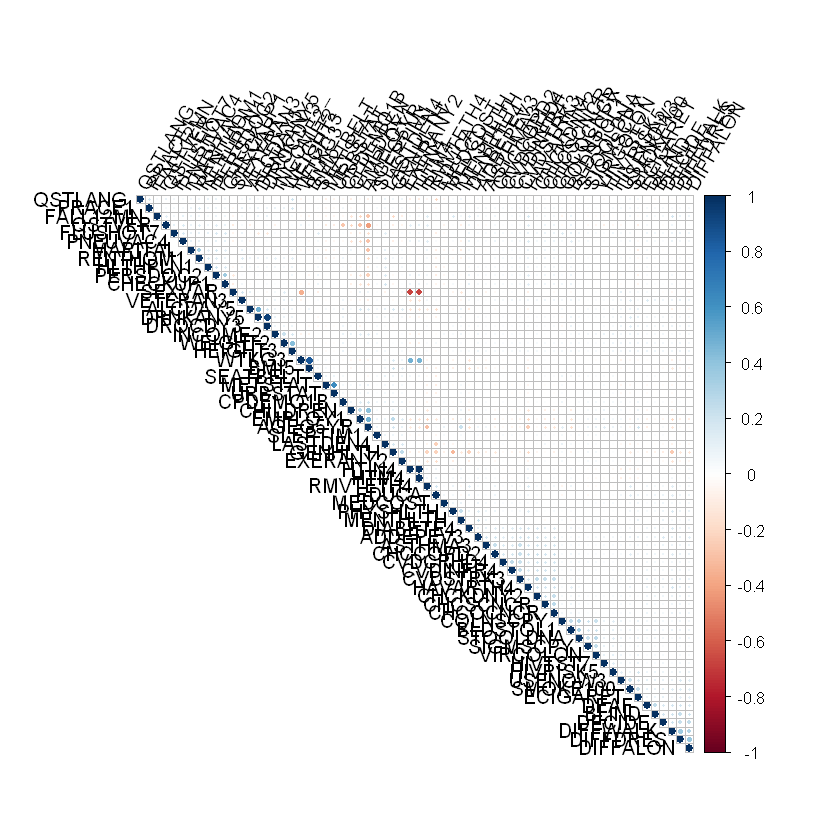

In [51]:
res <- cor(newDataset)
round(res, 2)

library(corrplot)
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 60)

In [52]:
#output_set <- c('ASTHMA3', 'CHCSCNCR', 'CHCCOPD2', 'CHCKDNY2', 'CVDCRHD4','CHCOCNCR','HAVARTH4','DIABETE4')
library(reshape2)
subset(melt(res), value > 0.9 & value < 1.0)
#no specific negative value that has high correlation 
subset(melt(res), value < -0.5 & value > -1.0)

,Var1,Var2,value
4022,HTM4,HTIN4,0.9924629
4087,HTIN4,HTM4,0.9924629
4290,DROCDY3_,DRNKANY5,0.9354195
4355,DRNKANY5,DROCDY3_,0.9354195


,Var1,Var2,value
61,HTIN4,SEXVAR,-0.6794339
62,HTM4,SEXVAR,-0.6745479
3961,SEXVAR,HTIN4,-0.6794339
4027,SEXVAR,HTM4,-0.6745479


In [53]:
##### It was observed that also we had HEIGHT attribute in three different columns, so the rest two will be removed. ###### 
duplicated_columns <- c('HTIN4','DRNKANY5','WTKG3','HEIGHT3')
newDataset <- newDataset[,-which(colnames(newDataset) %in% (duplicated_columns))]
NPREPROCESSING_prettyDataset(newDataset)

      Field Catagorical Symbols Name  Min    Mean  Max  Skew
1    SEXVAR       FALSE       0    0    1    1.54    2 -0.17
2   GENHLTH       FALSE       0    0    1    2.45    9  0.64
3  PHYSHLTH       FALSE       0    0    1   66.14   99 -1.03
4  MENTHLTH       FALSE       0    0    1   61.45   99 -0.73
5  HLTHPLN1       FALSE       0    0    1    1.12    9  9.71
6  PERSDOC2       FALSE       0    0    1    1.45    9  2.65
7   MEDCOST       FALSE       0    0    1    1.93    9  6.34
8  CHECKUP1       FALSE       0    0    1    1.46    9  3.45
9  EXERANY2       FALSE       0    0    1    1.25    9  4.47
10 SLEPTIM1       FALSE       0    0    1    7.94   99  8.79
11 CVDINFR4       FALSE       0    0    1    1.97    9  8.59
12 CVDCRHD4       FALSE       0    0    1    1.99    9  7.80
13 CVDSTRK3       FALSE       0    0    1    1.98    9 10.65
14  ASTHMA3       FALSE       0    0    1    1.88    9  5.01
15 CHCSCNCR       FALSE       0    0    1    1.93    9  6.52
16 CHCOCNCR       FALSE 

#### The refusal and don't know answers will be replaced with mode of the corresponding column.

In [54]:
#to find which columns have values labelled as refused (9,...), there should be looking at to column max value.
max_values = colMax(newDataset)
max_values

SEXVAR  GENHLTH PHYSHLTH MENTHLTH HLTHPLN1 PERSDOC2  MEDCOST CHECKUP1 
       2        9       99       99        9        9        9        9 
EXERANY2 SLEPTIM1 CVDINFR4 CVDCRHD4 CVDSTRK3  ASTHMA3 CHCSCNCR CHCOCNCR 
       9       99        9        9        9        9        9        9 
CHCCOPD2 HAVARTH4 ADDEPEV3 CHCKDNY2 DIABETE4 LASTDEN4 RMVTETH4  MARITAL 
       9        9        9        9        9        9        9        9 
   EDUCA RENTHOM1 CPDEMO1B VETERAN3  EMPLOY1 CHILDREN  INCOME2  WEIGHT2 
       9        9        9        9        9       99       99     9999 
    DEAF    BLIND   DECIDE DIFFWALK DIFFDRES DIFFALON SMOKE100  USENOW3 
       9        9        9        9        9        9        9        9 
 ALCDAY5 FLUSHOT7 PNEUVAC4 FALL12MN SEATBELT COLNSCPY SIGMSCPY BLDSTOL1 
     999        9        9       99        9        9        9        9 
STOOLDNA VIRCOLON  HIVTST7 HIVRISK5 ECIGARET   QSTVER  QSTLANG  METSTAT 
       9        9        9        9        9       23       20        2 
 URBSTAT   PRACE1  AGEG5YR     HTM4     BMI5 DROCDY3_ 
       2       99       14      241     9843      900

In [55]:
########WE SHOULD BE CAREFUL TO NOT INCLUDE CONTINOUS VARIABLES WHICH HAVE MAX 99,999 ETC. TO BELOW 2 OPERATIONS##########
#########refusal and missing values IN DISCRETE COLUMNS WHICH THE UNIQUE VALUES IN SHOULD BE MUCH LESS####################
####################### will be replaced with the corresponding column's mode. ###########################################
values = c(7,9)
#replaced values

for(i in colnames(newDataset))
      if(length(unique(newDataset[,i])) < 10)
          #Replace a value under a single DataFrame column
          newDataset[,i][newDataset[,i] %in% values] <- colModes[i]

#8 represents 'NONE or 0' in columns have length below 8, after the above operation done. So the values IN DISCRETE COLUMNS (8) should be replaced with 0.
values_none = c(8)

for(i in colnames(newDataset))
    if(length(unique(newDataset[,i])) < 8)
          #Replace a value under a single DataFrame column
          newDataset[,i][newDataset[,i] %in% values_none] <- 0
    
######### FOR AGE COLUMN THE REFUSED AND MISSED ONES LABELLED AS 14, it is different from the rest of the column's #########
########################## We should do some individual operation for itself.###############################################

columns_operated = c('AGEG5YR')
values = c(14)
#replaced values

newDataset <- swaptocolmodes(newDataset,columns_operated,values)

In [56]:
#THE COLUMNS HAVE MAX 99,999 ETC. HAVE PRESERVED AS SEEN IN BELOW. WE SHOULD TRY TO FIGURE OUT REPLACING THE MISSING/REFUSED VALUES IN THEM.
# max_values = colMax(newDataset)
# max_values

In [57]:
#SO THE LEFT ONES THAT MISSING/REFUSED VALUES REPRESENTED AS 77,99,777,999 NEEDS TO BE REMOVED, SEE ABOVE EXECUTION.

columns_operated = c('PHYSHLTH','MENTHLTH','SLEPTIM1','CHILDREN','INCOME2','FALL12MN','PRACE1')
values = c(77,99)
#replaced values

newDataset <- swaptocolmodes(newDataset,columns_operated,values)

columns_operated = c('DROCDY3_')
values = c(900)
    
newDataset <- swaptocolmodes(newDataset,columns_operated,values)
    
columns_operated = c('ALCDAY5')
values = c(777,999)
    
newDataset <- swaptocolmodes(newDataset,columns_operated,values)
    
columns_operated = c('WEIGHT2')
values = c(7777,9999)
    
newDataset <- swaptocolmodes(newDataset,columns_operated,values)

In [58]:
#88,... represents 'NONE or 0' in continuous columns. So the values IN COLUMNS should be replaced with 0.
columns_operated = c('PHYSHLTH','MENTHLTH','CHILDREN','FALL12MN')
values_none = c(88)

newDataset <- swaptozero(newDataset,columns_operated,values_none)
    
columns_operated = c('ALCDAY5')
values_none = c(888)

newDataset <- swaptozero(newDataset,columns_operated,values_none)

In [59]:
# prenewDataset <- NPREPROCESSING_dataset(newDataset, scaleFlag=TRUE)

In [60]:
#Seems there is a problem with WEIGHT2 as seems above, too much gap between minimum and maximum value 
#Once you get the codebook the weight in kilograms indicated as 9(value).These are also need to be fixed.
columns_operated = c('WEIGHT2')

for(i in colnames(newDataset))
      if(i %in% columns_operated)
          #Replace a value under a single DataFrame column
          newDataset[,i][newDataset[,i] >= 9000] <- colModes[i]

#SO THERE IS ALSO A PROBLEM WITH DIABETE4, THERE SHOULD BE EITHER HAVING OR NOT LABELS FOR THE OUTPUT COLUMN, IT SHOULD RETURN TO MODE.
columns_operated = c('DIABETE4')
values = c(2,4)

newDataset <- swaptocolmodes(newDataset,columns_operated,values)

#HAVING NOT DIABETES RETURNS 3, UNLIKE THE OTHER OUTPUT COLUMNS, IT SHOULD RETURN TO 2.
values = c(3)

for(i in colnames(newDataset))
      if(i %in% columns_operated)
          #Replace a value under a single DataFrame column
          newDataset[,i][newDataset[,i] %in% values] <- 2
    
max_values = colMax(newDataset)
max_values
ncol(newDataset)
#output_set <- c('ASTHMA3', 'CHCSCNCR', 'CHCCOPD2', 'CHCKDNY2', 'CVDCRHD4','CHCOCNCR','HAVARTH4','DIABETE4')

SEXVAR  GENHLTH PHYSHLTH MENTHLTH HLTHPLN1 PERSDOC2  MEDCOST CHECKUP1 
       2        5       30       30        2        3        2        4 
EXERANY2 SLEPTIM1 CVDINFR4 CVDCRHD4 CVDSTRK3  ASTHMA3 CHCSCNCR CHCOCNCR 
       2       24        2        2        2        2        2        2 
CHCCOPD2 HAVARTH4 ADDEPEV3 CHCKDNY2 DIABETE4 LASTDEN4 RMVTETH4  MARITAL 
       2        2        2        2        2        4        3        6 
   EDUCA RENTHOM1 CPDEMO1B VETERAN3  EMPLOY1 CHILDREN  INCOME2  WEIGHT2 
       6        3        6        2        6       82        8      999 
    DEAF    BLIND   DECIDE DIFFWALK DIFFDRES DIFFALON SMOKE100  USENOW3 
       2        2        2        2        2        2        2        3 
 ALCDAY5 FLUSHOT7 PNEUVAC4 FALL12MN SEATBELT COLNSCPY SIGMSCPY BLDSTOL1 
     230        2        2       76        5        2        2        2 
STOOLDNA VIRCOLON  HIVTST7 HIVRISK5 ECIGARET   QSTVER  QSTLANG  METSTAT 
       2        2        2        2        2       23       20        2 
 URBSTAT   PRACE1  AGEG5YR     HTM4     BMI5 DROCDY3_ 
       2        8       13      241     9843      100

[1] 62

In [61]:
######## FOR THE DATA EXPLORATION STAGE THE UNNORMALIZED VERSION OF THE PREPROCESSED DATASET WILL BE SAVED AS CSV. #########
# write.csv(newDataset, 'datapreprocessednotnormalized')

### Normalization Afterwards

In [62]:
newDataset <- Nrescaleentireframe(newDataset)
head(newDataset[,output_set])
######################## IN THE RAW DATASET 1 REPRESENT POSITIVE RESPONSE, 2 NEGATIVE RESPONSE #############################
#### SO ONCE NORMALIZATION MADE, 0 BECOME POSITIVE, 1 BECOME NEGATIVE, WE NEED TO ALSO SWAP AS 0 FOR -, 1 FOR + RESPONSE ###
newDataset<-swapOutputs(newDataset, output_set)
head(newDataset[,output_set])

ASTHMA3,CHCSCNCR,CHCCOPD2,CHCKDNY2,CVDCRHD4,CHCOCNCR,HAVARTH4,DIABETE4
0,0,0,1,1,0,0,0
0,1,1,1,1,1,0,1
1,1,1,1,1,0,0,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
0,1,0,1,1,1,0,0


ASTHMA3,CHCSCNCR,CHCCOPD2,CHCKDNY2,CVDCRHD4,CHCOCNCR,HAVARTH4,DIABETE4
1,1,1,0,0,1,1,1
1,0,0,0,0,0,1,0
0,0,0,0,0,1,1,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,1


In [63]:
################## THE DATASET FOR THE MODEL RUN IS READY, AND DISTRIBUTED TO THE GROUP MEMBERS ############################
# write.csv(newDataset,'brfssCleaned.csv')